In [20]:
import os
import illustris_python as il
import numpy as np

basePath = os.path.expanduser("~/Documents/uni/dsp/tng300/outputs")
snap = 99

# subhalo fields
subhalo_fields = [ 
    "SubhaloPos",       # Spatial position within the periodic box (of the particle with the minium gravitational potential energy). Comoving coordinate. Units: ckpc/h 
    "SubhaloVel",       # Peculiar velocity of the group, computed as the sum of the mass weighted velocities of all particles/cells in this group, of all types. No unit conversion is needed. Units: km/s
    "SubhaloMass",      # Total mass of all member particle/cells which are bound to this Subhalo, of all types. Particle/cells bound to subhaloes of this Subhalo are NOT accounted for. Units: 1e10 Msun/h
    "SubhaloMassType",  # Total mass of all member particle/cells which are bound to this Subhalo, separated by type. Particle/cells bound to subhaloes of this Subhalo are NOT accounted for. Units: 1e10 Msun/h
    "SubhaloSFRinRad",  # Sum of the individual star formation rates of all gas cells in this subhalo, but restricted to cells within the radius of 𝑉𝑚𝑎𝑥. Units Msun/yr
    "SubhaloFlag",      # Flag field indicating suitability of this subhalo for certain types of analysis. If zero, this subhalo should generally be excluded, and is not thought to be of cosmological origin.
    "SubhaloGrNr"       # Index into the Group table of the FOF host/parent of this Subhalo. 
]

sub = il.groupcat.loadSubhalos(basePath, snap, fields=subhalo_fields)

## Building a “central galaxy” sample (and why)

### What “central” means here

From https://www.tng-project.org/data/docs/faq/: 

Each FoF halo can have many subhalos: one “central/primary” and zero or more satellites.
The mapping fields you’ll use are:

SubhaloGrNr: subhalo → its parent FoF halo index

GroupFirstSub: FoF halo → the index of its “first / central” subhalo

### Why should we care (for Local Group analogues)

If we search for “pairs separated by 500–1000 kpc” in the full subhalo list, we'll find lots of satellite–satellite or satellite–central pairs inside large clusters and groups. Those are not what we mean by “two primary galaxies like MW and M31”.

Restricting to **centrals** is the simplest first-pass way to:

reduce contamination from dense environments,

reduce the number of objects dramatically (makes k-d tree searches cheaper),

make “pair = two main galaxies in two halos” closer to our intent.

### In the simulation analogue sense

When we look for a Local Group analogue in TNG, the intent is usually:

- pick two separate FoF halos of roughly MW/M31 mass,

- take the central subhalo from each as “MW” and “M31” analogues,

- allow satellites to exist around each, but we're focusing on the two primaries.

This is why the GroupFirstSub trick is useful: it gives us one primary galaxy per halo, so our “pair search” doesn’t accidentally pick two satellites inside a big cluster.

### Practically in the TNG group catalogs:

- Each FoF halo can contain 0 or more subhalos.

- If it contains subhalos, then there is exactly one “central/primary” and the rest are satellites/secondaries.

- The catalog field GroupFirstSub (stored in the Group / halo table) gives the index of the central subhalo for each halo. If a halo has no subhalos, GroupFirstSub == -1.

In [23]:
# Load the minimum halo fields needed for centrality
halos = il.groupcat.loadHalos(basePath, snap, fields=["GroupFirstSub", "GroupNsubs"])
first = halos["GroupFirstSub"]

# We create an array of length sub["count"] and mark those indices listed in GroupFirstSub (excluding -1). 
# GroupFirstSub points into the Subhalo table, so this is the direct way to label central subhalos.
is_central = np.zeros(sub["count"], dtype=bool)

valid = first[first >= 0]     # drop halos with no subhalos
is_central[valid] = True

# Combine centrality with the “useful galaxy” flag
# SubhaloFlag == 1 indicates that the subhalo is of cosmological origin and thus suitable for analysis
keep = (sub["SubhaloFlag"] == 1) & is_central

pos_c = sub["SubhaloPos"][keep]
vel_c = sub["SubhaloVel"][keep]
m_c   = sub["SubhaloMass"][keep]
mtype_c = sub["SubhaloMassType"][keep]
grnr_c  = sub["SubhaloGrNr"][keep]

print("All subhalos:", sub["count"])
print("Centrals (raw):", is_central.sum())
print("Centrals with SubhaloFlag==1:", keep.sum())

# Optional: check how many halos have no subhalos
print("Halos with no subhalos:", np.sum(first < 0))

All subhalos: 14485709
Centrals (raw): 11504190
Centrals with SubhaloFlag==1: 11501232
Halos with no subhalos: 6121702


## Stellar mass

Next we to compute stellar mass per central subhalo and keep only objects in a reasonable stellar-mass range. This matters because pair-finding on ~11.5 million centrals will still be heavy, while pair-finding on (say) a few hundred thousand “MW-ish” centrals is manageable.

### What “stellar mass” is in this table

SubhaloMassType is mass by particle type, in units of 1e10 Msun/h. The type mapping is the standard TNG particle-type convention: PartType4 = stars & wind particles, PartType1 = dark matter.

Mstar = SubhaloMassType[:, 4] * 1e10 / h (Msun)

Mdm = SubhaloMassType[:, 1] * 1e10 / h (Msun)

TNG300-1 lists "h" as 0.6774.

In [25]:
# hubble constant 'little h' in units of [100 km/s/Mpc]	0.6774
h = 0.6774  # TNG300-1 "little h" from the downloads page

# Stellar mass from SubhaloMassType:
# SubhaloMassType is in 1e10 Msun/h, and index 4 corresponds to stars & wind particles.
mstar = mtype_c[:, 4] * 1e10 / h  # Msun

# Optional: dark matter mass (same units logic, index 1 is DM).
mdm = mtype_c[:, 1] * 1e10 / h  # Msun

# Choose an initial stellar-mass window.
# This is not a "correct" MW/M31 definition, just a practical starting point to reduce the sample size.
mstar_min = 1e10
mstar_max = 5e11

# Build the filter.
keep_star = (mstar >= mstar_min) & (mstar <= mstar_max)

# Apply it to the central sample arrays.
pos_s   = pos_c[keep_star]
vel_s   = vel_c[keep_star]
mstar_s = mstar[keep_star]
mdm_s   = mdm[keep_star]
grnr_s  = grnr_c[keep_star]

print("Centrals before stellar-mass filter:", len(pos_c))
print("Centrals after stellar-mass filter:", len(pos_s))
print("h used:", h)
print("Stellar mass range [Msun]:", mstar_min, "to", mstar_max)

Centrals before stellar-mass filter: 11501232
Centrals after stellar-mass filter: 59929
h used: 0.6774
Stellar mass range [Msun]: 10000000000.0 to 500000000000.0


### Sanity plot (stellar mass vs DM mass) for filtered centrals

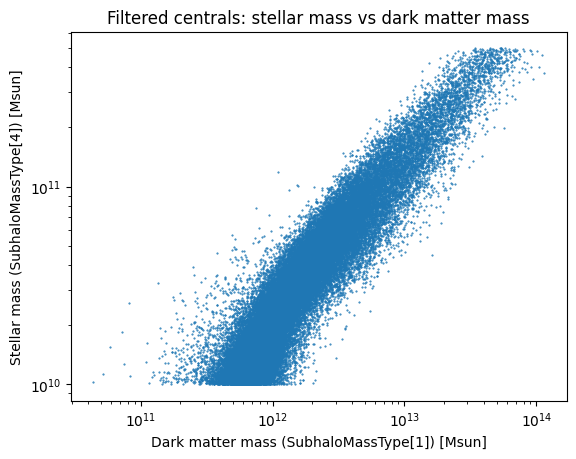

In [26]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(mdm_s, mstar_s, ".", markersize=1)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Dark matter mass (SubhaloMassType[1]) [Msun]")
plt.ylabel("Stellar mass (SubhaloMassType[4]) [Msun]")

plt.title("Filtered centrals: stellar mass vs dark matter mass")
plt.show()


### Prepare for pair-finding (define the distance window)

Key detail: SubhaloPos is in ckpc/h (comoving kpc divided by h).
At snapshot 99, z=0, so comoving = physical length, and the conversion to kpc is:

kpc = (ckpc/h) / h

equivalently, ckpc/h = kpc * h

In [29]:
import numpy as np
from scipy.spatial import cKDTree

# To handle periodic boundaries correctly, we need the simulation box size. The group catalog header provides BoxSize in the same units (ckpc/h).

header = il.groupcat.loadHeader(basePath, snap)
box = header["BoxSize"]  # ckpc/h
print("BoxSize [ckpc/h]:", box)

# Distances:
# SubhaloPos is in ckpc/h. The target window is 500–1000 kpc (physical).
# At z=0, converting kpc -> ckpc/h is: ckpc/h = kpc * h.
r_min = 500.0 * h
r_max = 1000.0 * h

# Periodic box size in ckpc/h from the header.
box = header["BoxSize"]  # ckpc/h 

# Build a periodic k-d tree.
# SciPy cKDTree supports periodic boundaries via the 'boxsize' argument. :contentReference[oaicite:3]{index=3}
tree = cKDTree(pos_s, boxsize=box)

# Get all unique index pairs (i < j) with separation <= r_max (in ckpc/h).
pairs = np.array(list(tree.query_pairs(r_max)), dtype=np.int64)

print("Candidate pairs within r_max (before extra cuts):", pairs.shape[0])

# Split indices.
i = pairs[:, 0]
j = pairs[:, 1]

# Exclude pairs that live in the same FoF halo.
# SubhaloGrNr maps each subhalo to its parent FoF halo index. :contentReference[oaicite:4]{index=4}
diff_host = grnr_s[i] != grnr_s[j]
i = i[diff_host]
j = j[diff_host]

print("Pairs after excluding same-host pairs:", i.shape[0])

# Compute separations with the minimum-image convention.
# This is needed to get the correct displacement vector in a periodic box.
dr = pos_s[j] - pos_s[i]
dr -= box * np.round(dr / box)

dist = np.linalg.norm(dr, axis=1)

# Apply the lower bound r_min.
in_window = dist >= r_min
i = i[in_window]
j = j[in_window]
dr = dr[in_window]
dist = dist[in_window]

print("Pairs in [r_min, r_max]:", i.shape[0])

# Convert separation to physical kpc for reporting and plotting.
dist_kpc = dist / h

# Relative velocity vector (km/s).
# SubhaloVel is peculiar velocity in km/s. :contentReference[oaicite:5]{index=5}
dv = vel_s[j] - vel_s[i]

# Radial and tangential relative velocities.
rhat = dr / dist[:, None]
v_r = np.einsum("ij,ij->i", dv, rhat)
v2 = np.einsum("ij,ij->i", dv, dv)
v_t = np.sqrt(np.maximum(0.0, v2 - v_r * v_r))

print("Separation stats [kpc]: min/median/max =", np.min(dist_kpc), np.median(dist_kpc), np.max(dist_kpc))
print("v_r stats [km/s]: min/median/max =", np.min(v_r), np.median(v_r), np.max(v_r))
print("v_t stats [km/s]: min/median/max =", np.min(v_t), np.median(v_t), np.max(v_t))


BoxSize [ckpc/h]: 205000.0
Candidate pairs within r_max (before extra cuts): 1755
Pairs after excluding same-host pairs: 1755
Pairs in [r_min, r_max]: 1751
Separation stats [kpc]: min/median/max = 512.3372 868.8477 999.6889
v_r stats [km/s]: min/median/max = -946.9707 -83.14221 1356.7693
v_t stats [km/s]: min/median/max = 1.4286412 107.331726 1626.0802


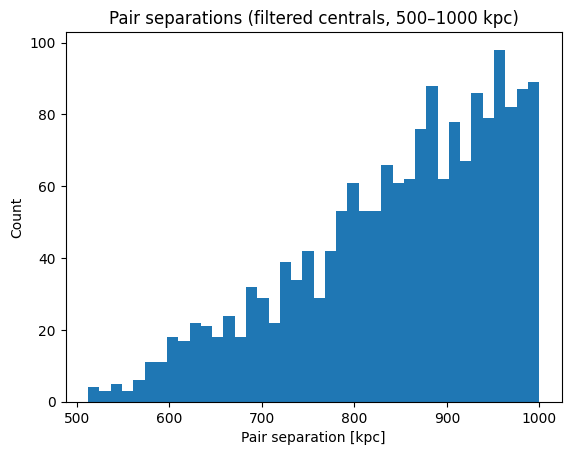

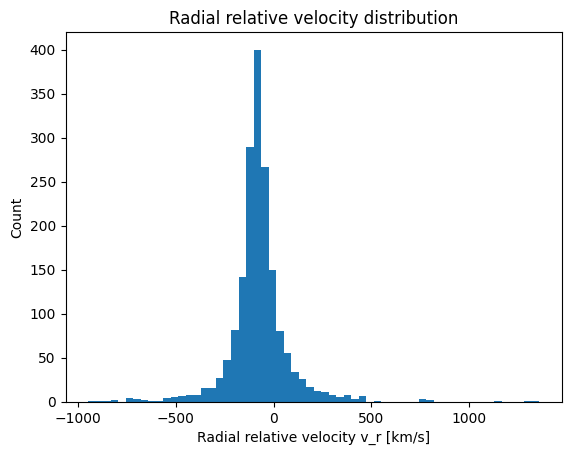

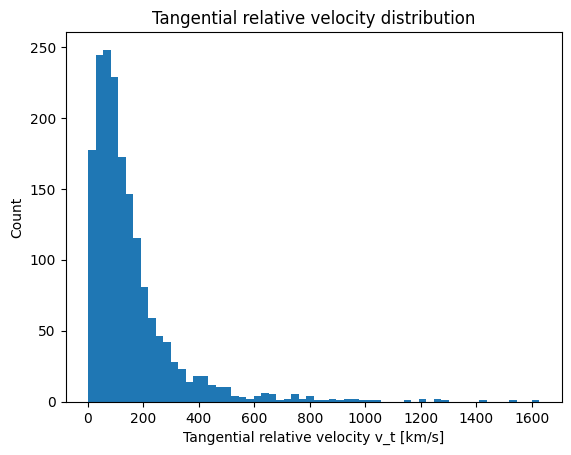

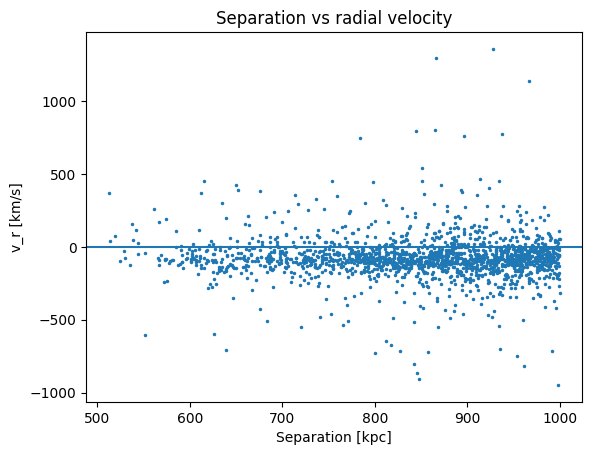

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Separation histogram (should be roughly uniform-ish inside the hard window)
plt.figure()
plt.hist(dist_kpc, bins=40)
plt.xlabel("Pair separation [kpc]")
plt.ylabel("Count")
plt.title("Pair separations (filtered centrals, 500–1000 kpc)")
plt.show()

# 2) Radial velocity histogram
plt.figure()
plt.hist(v_r, bins=60)
plt.xlabel("Radial relative velocity v_r [km/s]")
plt.ylabel("Count")
plt.title("Radial relative velocity distribution")
plt.show()

# 3) Tangential velocity histogram
plt.figure()
plt.hist(v_t, bins=60)
plt.xlabel("Tangential relative velocity v_t [km/s]")
plt.ylabel("Count")
plt.title("Tangential relative velocity distribution")
plt.show()

# 4) Separation vs v_r scatter
plt.figure()
plt.plot(dist_kpc, v_r, ".", markersize=3)
plt.xlabel("Separation [kpc]")
plt.ylabel("v_r [km/s]")
plt.title("Separation vs radial velocity")
plt.axhline(0.0)  # r


Fast pairs: 65 out of 1751


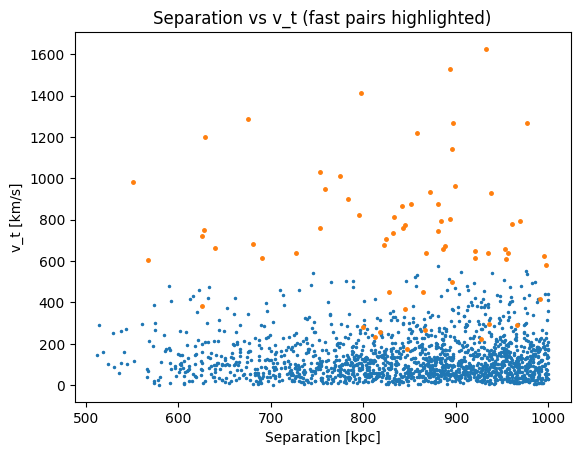

In [31]:
# Mark extreme outliers
# Identify very high-speed pairs for inspection (threshold is arbitrary, used only for debugging)
mask_fast = (np.abs(v_r) > 600) | (v_t > 600)

print("Fast pairs:", mask_fast.sum(), "out of", len(v_r))

plt.figure()
plt.plot(dist_kpc[~mask_fast], v_t[~mask_fast], ".", markersize=3)
plt.plot(dist_kpc[mask_fast],  v_t[mask_fast],  ".", markersize=5)
plt.xlabel("Separation [kpc]")
plt.ylabel("v_t [km/s]")
plt.title("Separation vs v_t (fast pairs highlighted)")
plt.show()


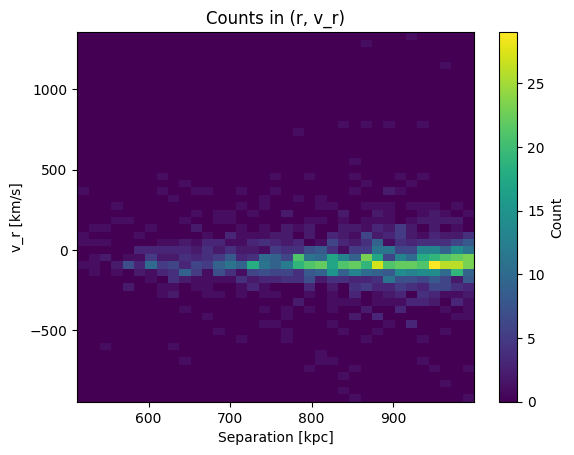

In [32]:
# Plot the joint distribution like the paper style (heatmap of counts in the (r, v_r) plane).
plt.figure()
plt.hist2d(dist_kpc, v_r, bins=[35, 50])
plt.xlabel("Separation [kpc]")
plt.ylabel("v_r [km/s]")
plt.title("Counts in (r, v_r)")
plt.colorbar(label="Count")
plt.show()
